In [3]:
#Imports for Drawing Section
from tkinter import *
import PIL

#IMG TO LC
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.image import imread
import numpy as np
from operator import itemgetter
from csv import writer

#Imports FOR LIGHT CURVE SEARCH
from sklearn.naive_bayes import GaussianNB
import skfuzzy as fuzz 
from skfuzzy import control as ctrl 

In [4]:
# DRAWING SECTION

#Save Function
def save():
    filename = "image.png"
    image1.save(filename)

#Paint Function
def paint( event ):
    x1, y1 = ( event.x - 1 ), ( event.y - 1 )
    x2, y2 = ( event.x + 1 ), ( event.y + 1 )
    cv.create_oval(x1, y1, x2, y2, fill = "black", width=5 )
    draw.line([x1, y1, x2, y2], fill="black", width=5)

#Canvas settings
width = 1000
height = 500
center = height//2
white = (255, 255, 255)
green = (0, 255, 0)

#Opens Canvas and allow drawing and saving
root = Tk()
cv = Canvas(root, width=width, height= height, bg="white")
cv.pack()
image1 = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(image1)
cv.pack(expand=YES, fill=BOTH)
cv.bind("<B1-Motion>", paint)
button=Button(text="save",command=save)
button.pack()
root.mainloop()

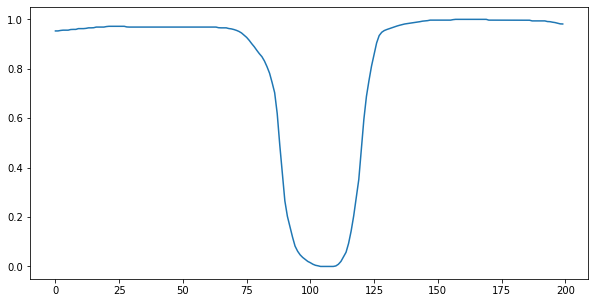

In [5]:
#IMAGE CONVERSION SECTION

#Loads data
img = imread('image.png')

#Converts image to array of numbers
def image_convert(img):
    lat = []
    grey = img[:,:,1]
    
    lat = 0
    lat_array = []
    for col in grey.T:
        lat = len(grey)
        temp_arr = []
        for i in col:
            lat -= 1
            if i == 0:
                temp_arr.append(lat)
        if temp_arr:
            num = sum(temp_arr) / len(temp_arr)
            lat_array.append(num)
    return lat_array

#Fits LC into 200 dataa points (local view)
def data_fit(data, fit=200):
    div = len(data) / fit
    result = pd.Series(data)
    smoothed = result.groupby(result.index // div).mean()
    normalized = (smoothed-min(smoothed))/(max(smoothed)-min(smoothed))
    
    plt.figure(figsize=(10,5))
    plt.plot(normalized)
    plt.show()
    return normalized

#Gets best LC from euclidean distance
data = image_convert(img)
final = data_fit(data)

In [6]:
#PRE-PROCESS DATA AND TRAIN MODEL

#Loads data for training, testing and system information
df = pd.read_csv('data/local_reduced.csv', sep=',', header=None)
synth_df = pd.read_csv('data/synth_data.csv', sep=',', header=None)
system_df = pd.read_csv('data/kepinfo.csv', sep=',', header=0)
kepid = system_df["kepid"]
koiname = system_df["kepoi_name"]

df = df.sample(frac=1).reset_index(drop=True)
synth_df = synth_df.sample(frac=1).reset_index(drop=True)

#Splits and normalises all local data
x_train = df.drop([0, 1, 2], axis=1)
x_train_norm = []
for i, row in x_train.iterrows():
    row_norm = (row-min(row))/(max(row)-min(row))
    x_train_norm.append(row_norm)
x_train_norm = pd.DataFrame(x_train_norm)
type_train = df[2]
y_train = df[0]
label_train = df[1]
x_train_norm.columns = range(x_train_norm.shape[1])

#Splits and normalises all synthetic data
synth_x_train = synth_df.drop([0], axis=1)
synth_x_train_norm = []
for i, row in synth_x_train.iterrows():
    row_norm = (row-min(row))/(max(row)-min(row))
    synth_x_train_norm.append(row_norm)
synth_x_train_norm = pd.DataFrame(synth_x_train_norm)
synth_y_train = synth_df[0]
synth_x_train_norm.columns = range(synth_x_train_norm.shape[1])

#Merges synthetic data with local data
x_frames = [synth_x_train_norm, x_train_norm]
x_train_all = pd.concat(x_frames)
y_frames = [synth_y_train, y_train]
y_train_all = pd.concat(y_frames)


#Trains model
gnb = GaussianNB()
gnb.fit(x_train_norm, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

D:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

D:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.

D:\Python\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



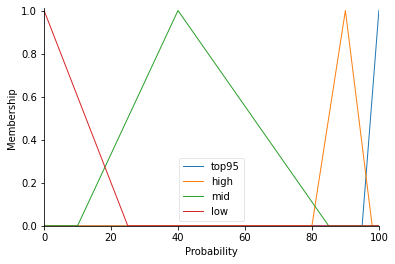

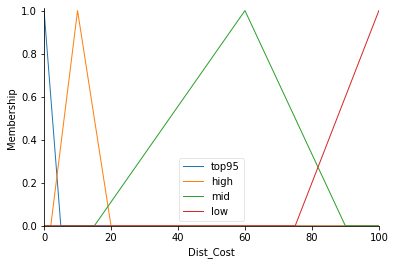

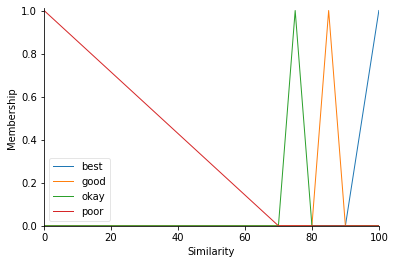

In [7]:
#DEFNIES FUZZY LOGIC

#Defines probability set
probability = ctrl.Antecedent(np.arange(0, 101, 1), 'Probability')
probability['top95'] = fuzz.trimf(probability.universe, [95, 100, 100])
probability['high'] = fuzz.trimf(probability.universe, [80, 90, 98])
probability['mid'] = fuzz.trimf(probability.universe, [10, 40, 85])
probability['low'] = fuzz.trimf(probability.universe, [0, 0, 25])

#Defines distance set
dist_cost = ctrl.Antecedent(np.arange(0, 101, 1), 'Dist_Cost')
dist_cost['top95'] = fuzz.trimf(dist_cost.universe, [0, 0, 5])
dist_cost['high'] = fuzz.trimf(dist_cost.universe, [2, 10, 20])
dist_cost['mid'] = fuzz.trimf(dist_cost.universe, [15, 60, 90])
dist_cost['low'] = fuzz.trimf(dist_cost.universe, [75, 100, 100])

#Defines similarity consequence set
similarity = ctrl.Consequent(np.arange(0, 101, 1), 'Similarity')
similarity['best'] = fuzz.trimf(similarity.universe, [90, 100, 100])
similarity['good'] = fuzz.trimf(similarity.universe, [80, 85, 90])
similarity['okay'] = fuzz.trimf(similarity.universe, [70, 75, 80])
similarity['poor'] = fuzz.trimf(similarity.universe, [0, 0, 70])

#Views all sets
probability.view()
dist_cost.view()
similarity.view()

#Defines rules for top95 probability
toprule1 = ctrl.Rule(probability['top95'] & dist_cost['top95'], similarity['best'])
toprule2 = ctrl.Rule(probability['top95'] & dist_cost['high'], similarity['good'])
toprule3 = ctrl.Rule(probability['top95'] & dist_cost['mid'], similarity['good'])
toprule4 = ctrl.Rule(probability['top95'] & dist_cost['low'], similarity['okay'])

#Defines rules for high probability
highrule1 = ctrl.Rule(probability['high'] & dist_cost['top95'], similarity['good'])
highrule2 = ctrl.Rule(probability['high'] & dist_cost['high'], similarity['good'])
highrule3 = ctrl.Rule(probability['high'] & dist_cost['mid'], similarity['okay'])
highrule4 = ctrl.Rule(probability['high'] & dist_cost['low'], similarity['okay'])

#Defines rules for mid probability
midrule1 = ctrl.Rule(probability['mid'] & dist_cost['top95'], similarity['good'])
midrule2 = ctrl.Rule(probability['mid'] & dist_cost['high'], similarity['okay'])
midrule3 = ctrl.Rule(probability['mid'] & dist_cost['mid'], similarity['okay'])
midrule4 = ctrl.Rule(probability['mid'] & dist_cost['low'], similarity['poor'])

#Defines rules for low probability
lowrule1 = ctrl.Rule(probability['low'] & dist_cost['top95'], similarity['okay'])
lowrule2 = ctrl.Rule(probability['low'] & dist_cost['high'], similarity['okay'])
lowrule3 = ctrl.Rule(probability['low'] & dist_cost['mid'], similarity['poor'])
lowrule4 = ctrl.Rule(probability['low'] & dist_cost['low'], similarity['poor'])

similarity_threshold = ctrl.ControlSystem([toprule1, toprule2, toprule3, toprule4, 
                                           highrule1, highrule2, highrule3, highrule4, 
                                           midrule1, midrule2, midrule3, midrule4, 
                                           lowrule1, lowrule2, lowrule3, lowrule4])
similarity_simulation = ctrl.ControlSystemSimulation(similarity_threshold)

In [8]:
#DEFINES FUNCTIONS FOR LIGHT CURVE SEARCH
#Searches for LC based on ID
def lc_search(search_id):
    result = ""
    found = False
    for i in range(len(kepid)):
        if kepid[i] == search_id:
            found = True
            result = koiname[i]
    if found == False:
        print("target not found")
    return result

#Calculates euclidean distance
def euclidean_distance(target):
    target = np.array(target)
    dist = []
    for i, row in x_train_norm.iterrows():
        a = target
        b = np.array(row)
        ED = np.linalg.norm(a-b)
        dist.append(ED)
    return dist

#Calculated sum DTW cost
def dtw_cost(s1, s2):
    s1 = s1.to_numpy()
    s2 = s2.to_numpy()
    l_s_1, l_s_2 = len(s1), len(s2)
    cost_matrix = np.zeros((l_s_1+1, l_s_2+1))
    for i in range(l_s_1+1):
        for j in range(l_s_2+1):
            cost_matrix[i, j] = np.inf
    cost_matrix[0, 0] = 0
    
    for i in range(1, l_s_1+1):
        for j in range(1, l_s_2+1):
            cost = abs(s1[i-1] - s2[j-1])
            #take last min from the window
            prev_min = np.min([cost_matrix[i-1, j], cost_matrix[i, j-1], cost_matrix[i-1, j-1]])
            cost_matrix[i, j] = cost + prev_min
            
    overall_cost = 0
    for x in cost_matrix:
        y = min(x)
        overall_cost = overall_cost + y
    return overall_cost

#Plot two light curves
def plot_similar(first, second):
    plt.figure(figsize=(10,5))
    plt.plot(first)
    plt.plot(second)
    plt.show()

#Create Link to system data
def create_link(search_id):
    link = "https://exoplanetarchive.ipac.caltech.edu/overview/" + lc_search(int(search_id))
    return link

#Search for similar LC using ID
def search_df(search_id):
    for data_index, row in df.iterrows():
        if row[0] == int(search_id):
            similar_lc = x_train_norm.iloc[data_index]
    return similar_lc

#Calculates Similarity for all light curves
def fuzzy_simulation(prob_all):
    similarity = []
    for all_index, all_row in prob_all.iterrows():
        similarity_simulation.input['Probability'] = all_row['prob']
        similarity_simulation.input['Dist_Cost'] = all_row['dist_cost']
        similarity_simulation.compute()
        # Output the result
        sim = similarity_simulation.output['Similarity']
        similarity.append(sim)
    return similarity

#Compares and normalises light curves using Euclidean distance
def compare_predicted(test):
    cost = euclidean_distance(test)
    cost = (cost-min(cost))/(max(cost)-min(cost))*100
    cost = pd.Series(cost)
    return cost

#Gets light curves
def get_light_curve(sort, ascend, test_lc, data, return_amount):
    final_sorted = data.sort_values(sort, ascending=ascend)
    top = final_sorted[:return_amount]
    for top_index, top_row in top.iterrows():
        search_id = int(top_row['kepid'])
        lc = search_df(str(search_id))
        print(top_row)
        print(create_link(search_id))
        plot_similar(test, lc)

prob          1.000000e+02
dist_cost     0.000000e+00
kepid         2.308957e+06
similarity    9.666667e+01
Name: 32, dtype: float64
https://exoplanetarchive.ipac.caltech.edu/overview/K06266.01


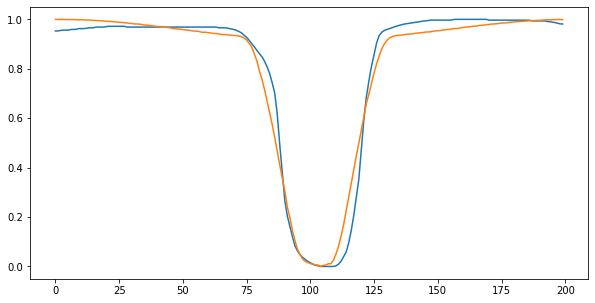

prob          1.000000e+02
dist_cost     0.000000e+00
kepid         2.308957e+06
similarity    9.666667e+01
Name: 32, dtype: float64
https://exoplanetarchive.ipac.caltech.edu/overview/K06266.01


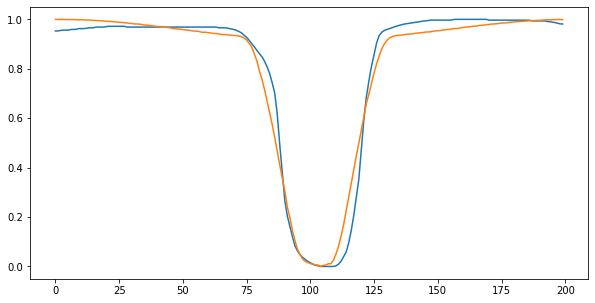

prob          1.000000e+02
dist_cost     0.000000e+00
kepid         2.308957e+06
similarity    9.666667e+01
Name: 32, dtype: float64
https://exoplanetarchive.ipac.caltech.edu/overview/K06266.01


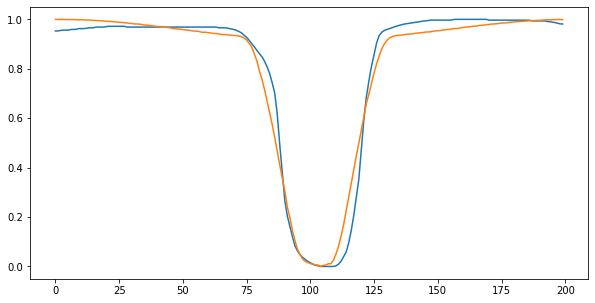

In [9]:
#LIGHT CURVE SEARCH
test = final
test_lc = final
test_lc = test_lc.to_numpy()
test_lc = test_lc.reshape(1, -1)
prob = gnb.predict_log_proba(test_lc)
prob = pd.Series(prob[0])
classes = pd.DataFrame(gnb.classes_)
euclid = pd.DataFrame()

dist_cost = compare_predicted(test)
prob = (prob-min(prob))/(max(prob)-min(prob))*100

dist_cost = pd.concat([dist_cost, y_train], axis=1)
dist_cost.columns = ['dist_cost','kepid']
dist_cost = dist_cost.sort_values('kepid', ascending=True).reset_index(drop=True)
prob_all = pd.concat([prob, dist_cost], axis=1)
prob_all.columns = ['prob', 'dist_cost','kepid']
#Defines similarity and concatenates with all data
similarity = fuzzy_simulation(prob_all)
similarity = pd.Series(similarity)
final_sim = pd.concat([prob_all, similarity], axis=1)
final_sim.columns = ['prob', 'dist_cost','kepid', 'similarity']

get_light_curve('prob', False, test, final_sim, 1)
get_light_curve('dist_cost', True, test, final_sim, 1)
get_light_curve('similarity', False, test, final_sim, 1)